In [1]:
#Importing library
import zipfile
import os
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.regularizers import l2
from tensorflow.keras import layers, models, optimizers, losses, callbacks,\
                             regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from pathlib import Path
from google.colab import drive
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
#Mounting google drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
#Unzip image folder
!unzip /content/gdrive/MyDrive/Group_Project_Data

Streaming output truncated to the last 5000 lines.
  inflating: Group_Project_Data/Train/Fake/img_2189.png  
  inflating: __MACOSX/Group_Project_Data/Train/Fake/._img_2189.png  
  inflating: Group_Project_Data/Train/Fake/img_460.png  
  inflating: __MACOSX/Group_Project_Data/Train/Fake/._img_460.png  
  inflating: Group_Project_Data/Train/Fake/img_1480.png  
  inflating: __MACOSX/Group_Project_Data/Train/Fake/._img_1480.png  
  inflating: Group_Project_Data/Train/Fake/img_1494.png  
  inflating: __MACOSX/Group_Project_Data/Train/Fake/._img_1494.png  
  inflating: Group_Project_Data/Train/Fake/img_474.png  
  inflating: __MACOSX/Group_Project_Data/Train/Fake/._img_474.png  
  inflating: Group_Project_Data/Train/Fake/img_312.png  
  inflating: __MACOSX/Group_Project_Data/Train/Fake/._img_312.png  
  inflating: Group_Project_Data/Train/Fake/img_2823.png  
  inflating: __MACOSX/Group_Project_Data/Train/Fake/._img_2823.png  
  inflating: Group_Project_Data/Train/Fake/img_1319.png  
  inflat

In [4]:
!unzip /content/gdrive/MyDrive/Group_Project_Data.zip > /dev/null

replace __MACOSX/._Group_Project_Data? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [5]:
# Data fetching
train_image_file ='/content/Group_Project_Data/Train'
test_image_file= '/content/Group_Project_Data/Valid'

# Define the input shape of the images
input_shape = (64, 64)

# Set the batch size for training and testing
train_batch_size = 94
test_batch_size = 32

# Create an image data generator for the training set
train_datagen = ImageDataGenerator( rescale=1./255)

# Create an image data generator for the testing set
test_datagen = ImageDataGenerator(rescale=1./255)

# Create the image generators
train_generator = train_datagen.flow_from_directory(
    train_image_file,
    target_size=input_shape,
    batch_size=32,
    color_mode='grayscale',
    class_mode='binary',
    classes=['Real', 'Fake'],
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    test_image_file,
    target_size=input_shape,
    batch_size=32,
    class_mode='binary',
    color_mode='grayscale',
    classes=['Real', 'Fake'],
    shuffle=True
)
# Get the number of training and test samples
num_train_samples = train_generator.samples
num_test_samples = test_generator.samples

# Get the number of classes
num_classes = train_generator.num_classes

# Get the class labels
class_labels = list(train_generator.class_indices.keys())

Found 6000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [6]:
# Data Preprocessing
# Check that the counts match the expected values
expected_train_count = 6000
expected_test_count = 2000

num_batches = len(train_generator)
#concatenating the batches to form the complete training dataset
x_train = []
y_train = []
# Loop over each batch in the train generator and extract the data
for i in range(num_batches):
    x_batch, y_batch = next(train_generator)
    x_train.append(x_batch)
    y_train.append(y_batch)

# Concatenate the input and output arrays
x_train = np.concatenate(x_train, axis=0)
y_train = np.concatenate(y_train, axis=0)



# Set the number of batches in the test generator
num_batches = len(test_generator)

# Initialize empty lists for x_test and y_test
x_test = []
y_test = []

# Loop over each batch in the test generator and extract the data
for i in range(num_batches):
    x_batch, y_batch = next(test_generator)
    x_test.append(x_batch)
    y_test.append(y_batch)
# Concatenate the input and output arrays
x_test = np.concatenate(x_test, axis=0)
y_test = np.concatenate(y_test, axis=0)


In [7]:
#reinitizing the weight of model
def reinitialize(model):
    # Loop over the layers of the model
    for l in model.layers:
        # Check if the layer has initializers
        if hasattr(l,"kernel_initializer"):
            # Reset the kernel weights
            l.kernel.assign(l.kernel_initializer(tf.shape(l.kernel)))
        if hasattr(l,"bias_initializer"):
            # Reset the bias
            l.bias.assign(l.bias_initializer(tf.shape(l.bias)))

In [8]:
#Model with 2 conv layer and 4 pooling layer
inp = tf.keras.layers.Input((64, 64, 1),dtype='float32', name='inp')
conv_1 = tf.keras.layers.Conv2D(32,(3,3),activation='relu',padding='same', 
                            name='conv_1')(inp)
pool_1 = tf.keras.layers.MaxPooling2D((2,2),name='pool_1')(conv_1)
pool_2 = tf.keras.layers.MaxPooling2D((2,2),name='pool_2')(pool_1)
pool_3 = tf.keras.layers.MaxPooling2D((2,2),name='pool_3')(pool_2)
conv_2 = tf.keras.layers.Conv2D(8,(3,3),activation='relu',padding='same',
                          name='conv_2')(pool_3)                     
pool_4 = tf.keras.layers.MaxPooling2D((2,2),name='pool_4')(conv_2)
flat = tf.keras.layers.Flatten()(pool_4)

# Add regularization and dropout
fc_2 = tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001))(flat)
fc_2 = tf.keras.layers.Dropout(0.1)(fc_2)
output = tf.keras.layers.Dense(1, activation='sigmoid')(fc_2)

class_model = models.Model(inputs=inp,outputs=output,name='class_model')

print(class_model.summary())


Model: "class_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inp (InputLayer)            [(None, 64, 64, 1)]       0         
                                                                 
 conv_1 (Conv2D)             (None, 64, 64, 32)        320       
                                                                 
 pool_1 (MaxPooling2D)       (None, 32, 32, 32)        0         
                                                                 
 pool_2 (MaxPooling2D)       (None, 16, 16, 32)        0         
                                                                 
 pool_3 (MaxPooling2D)       (None, 8, 8, 32)          0         
                                                                 
 conv_2 (Conv2D)             (None, 8, 8, 8)           2312      
                                                                 
 pool_4 (MaxPooling2D)       (None, 4, 4, 8)           

In [9]:
#Calling Reinitialise method
reinitialize(class_model)

/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [10]:
# Model Optimization

opt = tf.keras.optimizers.SGD(learning_rate=0.001)
class_model.compile(opt,
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

In [11]:
#Model fit
history = class_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=20,
    validation_data=test_generator,
    validation_steps=test_generator.samples // test_generator.batch_size,
    callbacks=[early_stopping]
)

Epoch 1/20
187/187 [==============================] - 18s 26ms/step - loss: 0.8969 - accuracy: 0.5318 - val_loss: 0.8963 - val_accuracy: 0.5297
Epoch 2/20
187/187 [==============================] - 3s 17ms/step - loss: 0.8960 - accuracy: 0.5551 - val_loss: 0.8955 - val_accuracy: 0.5373
Epoch 3/20
187/187 [==============================] - 4s 24ms/step - loss: 0.8952 - accuracy: 0.5563 - val_loss: 0.8948 - val_accuracy: 0.5514
Epoch 4/20
187/187 [==============================] - 4s 20ms/step - loss: 0.8945 - accuracy: 0.5757 - val_loss: 0.8941 - val_accuracy: 0.5590
Epoch 5/20
187/187 [==============================] - 4s 21ms/step - loss: 0.8939 - accuracy: 0.5861 - val_loss: 0.8935 - val_accuracy: 0.5716
Epoch 6/20
187/187 [==============================] - 5s 25ms/step - loss: 0.8932 - accuracy: 0.5963 - val_loss: 0.8928 - val_accuracy: 0.5817
Epoch 7/20
187/187 [==============================] - 4s 20ms/step - loss: 0.8925 - accuracy: 0.6069 - val_loss: 0.8922 - val_accuracy: 0.590

In [14]:
#Saving Model
class_model.save('/content/Group_Project_Model')

In [15]:
#Zipping into drive location
!zip -r /content/gdrive/MyDrive/Group_Project_Model.zip /content/Group_Project_Model

updating: content/Group_Project_Model/ (stored 0%)
updating: content/Group_Project_Model/assets/ (stored 0%)
updating: content/Group_Project_Model/saved_model.pb (deflated 89%)
updating: content/Group_Project_Model/variables/ (stored 0%)
updating: content/Group_Project_Model/variables/variables.data-00000-of-00001 (deflated 9%)
updating: content/Group_Project_Model/variables/variables.index (deflated 58%)
updating: content/Group_Project_Model/keras_metadata.pb (deflated 91%)
updating: content/Group_Project_Model/fingerprint.pb (stored 0%)


In [16]:
# Testing the saved model
loaded_model = tf.keras.models.load_model('/content/Group_Project_Model')
loaded_model.summary()

Model: "class_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inp (InputLayer)            [(None, 64, 64, 1)]       0         
                                                                 
 conv_1 (Conv2D)             (None, 64, 64, 32)        320       
                                                                 
 pool_1 (MaxPooling2D)       (None, 32, 32, 32)        0         
                                                                 
 pool_2 (MaxPooling2D)       (None, 16, 16, 32)        0         
                                                                 
 pool_3 (MaxPooling2D)       (None, 8, 8, 32)          0         
                                                                 
 conv_2 (Conv2D)             (None, 8, 8, 8)           2312      
                                                                 
 pool_4 (MaxPooling2D)       (None, 4, 4, 8)           

In [53]:
# Model Evalution
# Evaluate the model on the test data
test_loss, test_acc = class_model.evaluate(x_test, y_test, verbose=2)

# Print the test loss and accuracy metrics
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)


63/63 - 0s - loss: 0.8831 - accuracy: 0.7415 - 173ms/epoch - 3ms/step
Test loss: 0.8831181526184082
Test accuracy: 0.7415000200271606


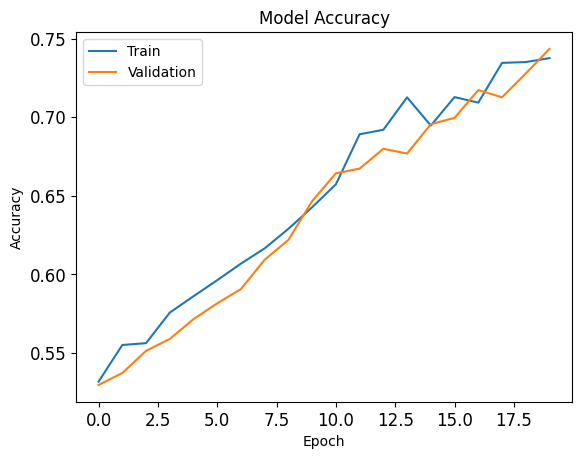

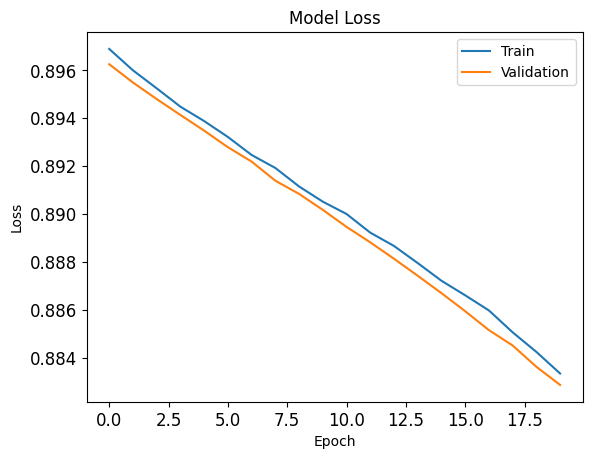

In [28]:
# Ploting
# Visualize the training history

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()


<ipython-input-13-996b57ad9cfc>:3: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred = class_model.predict_generator(x_test)


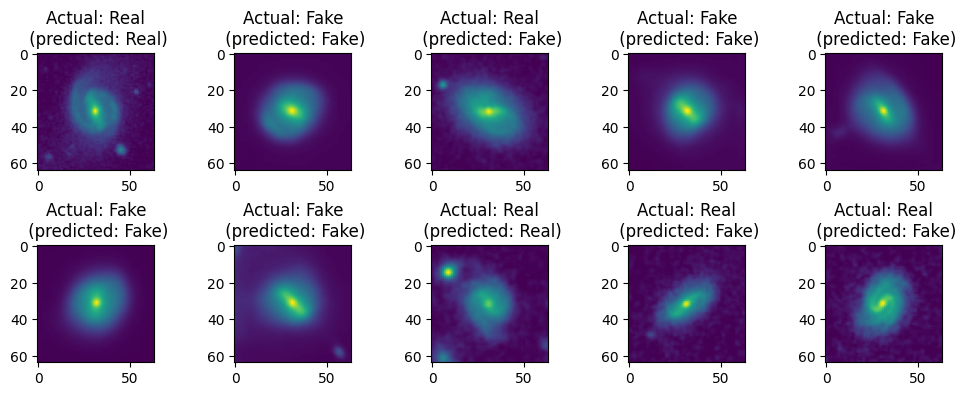

In [13]:
  # prediction
# Make predictions on a new test dataset
y_pred = class_model.predict_generator(x_test)

# Print the predicted classes for the first 10 images
# List of label names
class_names = ['Real', 'Fake']
predictions = tf.where(y_pred <= 0.5, 0, 1)
predictions = np.array(predictions)
fig, ax = plt.subplots(2, 5, figsize=(10,4))
ax = ax.flatten()
for i in range(10):
    ax[i].imshow(x_test[i])
    ax[i].set_title(f"Actual: {class_names[int(y_test[i])]}\n (predicted: {class_names[int(predictions[i])]})")
plt.tight_layout()
plt.show()
